<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2022/blob/main/Barrages/Simul_EbbGeneration_V02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/libs/mpl_utils.py

In [ ]:
from dataclasses import dataclass
import matplotlib.pyplot as mpl
import numpy as np
import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']

In [ ]:
mpl.rcParams["figure.figsize"] = (12, 3)
#np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning) 

# Algebraic models

## Barrage simulator in ebb mode

The following models were implemented to simulate the tidal power plant:

* The basin
* The tide
* Hydraulic turbines
* Electrical generators
* Sluice gates
* Power plant controller

## Turbine hill map and turbine operating curve

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/TurbineHill_Plot.svg" width="500px" style="display:inline">


### Turbine mode

Turbine dimensionless numbers

* Rotational speed $$n_{11}=\dfrac{\Omega D}{\sqrt{gh}}.$$

* Flow rate $$Q_{11} = \dfrac{Q}{D^2\sqrt{gh}}.$$

* Efficiency $$\eta_\mathrm{turb} = \dfrac{P_\mathrm{turb}}{P_\mathrm{avail}}.$$


The power available to the turbine is given by 

$$P_\mathrm{avail} = \rho g h \, Q,$$

where

$$Q = D^2 \sqrt{gh} \, Q_{11}\big( n_{11} \big).$$

The turbine is to be operated at constant rotational speed due to the use of a synchronous generator (see generator class).

The energy harvest by the turbine is

$$\dfrac{\text{d} E_\text{turb}}{\text{d}t}=\eta_\text{turb}\big( n_{11}\big) \, P_\text{avail},$$

### Sluicing mode

The in sluicing mode the "turbine" is modelled as 

$$Q_\mathrm{turb}^\mathrm{sluice} = C_\mathrm{d} A_\mathrm{turb} \sqrt{ 2 g h }$$

where $A_\mathrm{turb}$ is the area corresponding to the turbine rotor diameter.



In [ ]:
@dataclass
class TurbineModel:

  # flow rate: efficiency: red line of the map 
  poly_CQ1: np.poly1d = np.poly1d( np.array([0.16928201, 0.08989368]) )

  # flow rate: green line of the map
  poly_CQ2: np.poly1d = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03, 
                                         -9.25873626e-02,  1.75687197e+00]) )

  # efficiency: red line of the map
  poly_CE1: np.poly1d = np.poly1d( np.array([-0.02076456, 0.20238444, 
                                              0.48984553]) )
  # efficiency: green line of the map
  poly_CE2: np.poly1d = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,  
                                             6.86081825e-04,  7.93083108e-01]) )

  # n11 interpolation domain
  n11_min: float =  4.38
  n11_max: float = 17.17

  # other data
  ga: float = 9.8         # gravity aceleration
  ρw: float = 1025.0      # water density
  CD_sluice: float = 1.0  # discharge coefficient in sluice mode

  #=============================================================================
  def __init__( self, D_turb, Omega ) -> None:

    self.Omega = Omega    # we are assuming constant rotational speed model
    self.D_turb = D_turb  # turbine rotor diameter
    self.A_turb = np.pi*(D_turb/2.0)**2 

    # constants used in for computing n11 and QT
    self.CT0 = Omega * D_turb / np.sqrt( self.ga )
    self.CT1 = D_turb**2 * np.sqrt( self.ga )

  def n11_range( self ) -> ( float, float ):
    return ( self.n11_min, self.n11_max )

  # dimensionless velocity
  def n11( self, h: float ) -> float:
    # avoid division by zero on h = 0.0
    return self.CT0 / np.sqrt( max( h, 1E-3 ) ) 

  # dimensionless flow rate
  def Q11( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < 7.92193:
      return self.poly_CQ1( n11 ) 
    else:
      return self.poly_CQ2( n11 )

  # efficiency
  def eta( self, n11: float ) -> float:
    assert( n11 >= self.n11_min ), "n11 small than admissable minimum"
    assert( n11 <= self.n11_max ), "n11 greater than admissable maximum"
    if n11 < 7.92193:
      return self.poly_CE1( n11 ) * 0.912
    else:
      return self.poly_CE2( n11 ) * 0.912

  # computing operational data
  def operating_point( self, h: float ) -> float:
    n11 = self.n11( h )
    QT = self.CT1 * self.Q11( n11 ) * np.sqrt( h )
    PH = self.ρw * self.ga * h * QT
    ηT = self.eta( n11 )
    return QT, PH, ηT  
  
  # turbine flow rate in sluice mode
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.A_turb * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

tmp = TurbineModel( 5.5, 92.9 )
tmp.n11_range()

(4.38, 17.17)

## Generator efficiency curve

The electrical generator is assumed to be a synchronous machine. The rotational speed is given by

$$\Omega = \dfrac{2\pi f}{p}$$

where $f$ is the electrical grid frequency and $p$ is the number of pairs of poles.

The generator efficiency is computed as a function of the load

$$\Lambda = \dfrac{P_\mathrm{turb}}{P_\mathrm{gen}^\mathrm{rated}}$$


<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/GeneratorEff_plot.svg" width="400px" style="display:inline">


In [ ]:
@dataclass
class GeneratorModel:

  # red part of the curve
  poly_C1: np.poly1d = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03, 
                                            -3.80834059e+02,  2.70423225e+01, 
                                             3.29394948e-03]) )
  # green part of the curve
  poly_C2: np.poly1d = np.poly1d( np.array([-1.16856952,  3.31172525, 
                                            -3.44296217,  1.5416029 ,  
                                             0.71040716]) )
    
  #=============================================================================
  def __init__( self, Pgen_rated: float ) -> None:
    self.Pgen_rated = Pgen_rated

  # efficiency as a function of the load
  def eta( self, Pturb: float ) -> float:
    load = Pturb / self.Pgen_rated

    assert( load >= 0.0 ), "turbine power lower than zero"
    assert( load <= 1.0 ), "generator rated power to low (%f)" % Pturb
    if load < 0.12542:
      return self.poly_C1( load ) 
    else:
      return self.poly_C2( load )

## Sluice gates

The sluice gates are modelled as a turbulent pressure drop

$$Q_\mathrm{sluice} = C_\mathrm{d} A \sqrt{ 2 g h }$$

typical discharge coefficients for barrage sluice gates are within the range $0.8 \le C_\mathrm{d} \le 1.2$. Here we use $C_\mathrm{d}=1.0$. 

In [ ]:
@dataclass
class GateModel:
  ga: float = 9.8
  CD_sluice: float = 1.0

  #=============================================================================
  def __init__( self, Area: float ) -> None:
    self.Area = Area

  # flow rate as a function of h
  def sluicing( self, h: float ) -> float:
    QS = -self.CD_sluice * self.Area * np.sqrt( 2.0 * self.ga * max( -h, 0.0 ) )
    return QS

## Tide modelling

The tide level is assumed to be a trignometric series

$$z(t) = \sum_i^n \zeta_i \cos\left( \omega_i t + \phi_i \right).$$

In [ ]:
@dataclass
class TideModel:
 
  #  ζ_tide, period and φ_tide are vector to allow simulate 
  # multi-component tides
  def __init__( self, ζ_tide: np.array, ω_tide: np.array, φ_tide:np.array ) -> None:
      self.ζ_tide = ζ_tide
      self.ω_tide = ω_tide 
      self.φ_tide = φ_tide
    
  # tide level as a function t
  def level( self, t: float ) -> float:    
      return np.sum( self.ζ_tide * np.cos( self.ω_tide * t + self.φ_tide ) )

# Differential models

## Basin modelling

The basin is modelled as a "shoe box". The out flow is denoted as positive.

The instantaneous basin volume is computed from

$$\dfrac{\mathrm{d}V}{\mathrm{d}t}=-Q.$$

The integrating with the Euler method we get

$$V(t+\Delta t)=V(t)-\Delta t\,Q.$$

The instantaneous basin level is given by

$$h = \dfrac{V}{A_\mathrm{basin}},$$

where $A_\mathrm{basin}$ is the basin area.

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2022/main/Barrages/Figures/BasinShoeBox_MWL.svg" width="300px" style="display:inline">



In [ ]:
class BasinModel:

  def __init__( self, A_basin, h0_basin ):
    self.A_basin = A_basin        # Basin area
    self.V0 = A_basin * h0_basin  # initial basin level
    self.V = None

  # set initial condition
  def start( self ):
    self.V = self.V0
    return self.level()

  # compute volume 
  def integrate( self, delta_t, Q ):
    self.V = self.V - delta_t * Q
    return self.level()

  # water level in the base 
  def level( self ):
      return self.V / self.A_basin

## Power plant operation model 

The power plant modelling and control is based in the following finite state machine

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/BarrageExamples/Figures/BarrageEbbMode.svg" width="700px" style="display:inline">

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/BarrageExamples/Figures/EbbOperation_FSM.svg" width="700px" style="display:inline">

In [ ]:
class EbbOperations_FSM:

  #===================================================
  def __init__( self ):
    self.transitions = [ self.__transition_0_1, 
                         self.__transition_1_2,
                         self.__transition_2_3,
                         self.__transition_3_4,
                         self.__transition_4_1 ]

    self.states = [ self.__run_state_hold,
                    self.__run_state_generate,
                    self.__run_state_hold,
                    self.__run_state_fill,
                    self.__run_state_hold ]         

    self.cur_state = 0

  #== TRANSITIONS ====================================
  def __transition_0_1( self, h, h_start, n11, n11_max ):
    if h > h_start:
      self.cur_state = 1

  def __transition_1_2( self, h, h_start, n11, n11_max ):
    if n11 > n11_max:
      self.cur_state = 2

  def __transition_2_3( self, h, h_start, n11, n11_max ):
    if h < 0.0:
      self.cur_state = 3

  def __transition_3_4( self, h, h_start, n11, n11_max ):
    if h > 0.0:
      self.cur_state = 4

  def __transition_4_1( self, h, h_start, n11, n11_max ):
    if h > h_start:
      self.cur_state = 1

  #== STATES =========================================
  def __run_state_hold( self, h, _ ):
    QS = QT = PH = ηT = ηG = 0
    return QS, QT, PH, ηT, ηG

  def __run_state_generate( self, h, models ):
    QS = 0.0
    QT, PH, ηT = models.turbine.operating_point( h )
    ηG = models.generator.eta( ηT * PH )
    return QS, QT, PH, ηT, ηG

  def __run_state_fill( self, h, models ):
    QS = models.gate.sluicing( h )
    QT = models.turbine.sluicing( h )
    PH = ηT = ηG = 0.0
    return QS, QT, PH, ηT, ηG

  #== RUN FSM ========================================
  def transition( self, h, h_min, n11, n11_max ):
    self.transitions[ self.cur_state ]( h, h_min, n11, n11_max )
    return self.cur_state

  def run_state( self, h, models ):
    return self.states[ self.cur_state ]( h, models )

  #== RUN POWER PLANT MODEL ==========================
  def run_model( self, delta_t, t_final, models ):


    #==============================================
    t = delta_t                    # time step
    n = int( t_final / delta_t )   # number of time steps

    #==============================================
    # store computed time series
    time_vec = np.zeros( n )  # time 
    tide_vec = np.zeros( n )  # tide level

    s_vec  = np.zeros( n )    # control stages
    h_vec  = np.zeros( n )    # water height level
    z_vec  = np.zeros( n )    # basin level
    QS_vec = np.zeros( n )    # sluice gates + turbine flow rate on sluicing
    QT_vec = np.zeros( n )    # turbine flow rate
    PH_vec = np.zeros( n )    # hydraulic power
    ηT_vec = np.zeros( n )    # turbine efficiency
    ηG_vec = np.zeros( n )    # generator efficiency

    #==============================================
    n11_min, n11_max = models.turbine.n11_range()
    z = models.basin.start()
    ζ = models.tide.level( 0.0 )
    h = z - ζ
    
    #==============================================
    tide_vec[0] = ζ
    h_vec[0] = h
    z_vec[0] = z

    #==============================================
    for i in range( 1, n ):

      t = i * delta_t

      # select state
      h_start = models.turbine_starting_head.head( t )
      n11 = models.turbine.n11( h )
      state = self.transition( h, h_start, n11, n11_max )

      # compute state
      QS, QT, PH, ηT, ηG = self.run_state( h, models )

      # new basin condition as a function of flow rate (turbines+sluice gates) 
      z = models.basin.integrate( delta_t, models.n_turbs*QT + models.n_gates*QS )
      ζ = models.tide.level( t )
      h = z - ζ

      #==========================================
      # store data for post-processing
      time_vec[i] = t
      tide_vec[i] = ζ

      s_vec[i]  = state
      h_vec[i]  = h
      z_vec[i]  = z
      QS_vec[i] = QS
      QT_vec[i] = QT
      PH_vec[i] = PH
      ηT_vec[i] = ηT
      ηG_vec[i] = ηG
  
    return time_vec, tide_vec, s_vec, h_vec, z_vec, QS_vec, \
            QT_vec, PH_vec, ηT_vec, ηG_vec

# Instantiate all the components in one class 

In [ ]:
class Models:

    def __init__( self, A_basin, h0_basin,
                  n_turbs, Dturb, 
                  grid_freq, ppoles, Pgen_rated, 
                  n_gates, Agates,
                  ζ_tide, ω_tide, φ_tide,
                  turbine_starting_head ):

      # synchronous rotational speed
      Omega = 2 * np.pi * grid_freq / ppoles

      self.n_turbs = n_turbs # number of turbines
      self.n_gates = n_gates  # number of sluice gates

      self.turbine = TurbineModel( D_turb = Dturb, Omega = Omega )
      self.generator = GeneratorModel( Pgen_rated = Pgen_rated )
      
      self.gate = GateModel( Area = Agates )
      self.tide = TideModel( ζ_tide, ω_tide, φ_tide )
      self.basin = BasinModel( A_basin, h0_basin )

      self.turbine_starting_head = turbine_starting_head

# Configuration parameters

In [ ]:
# minimum head to start the turbine as a function of time
class TurbineStartingHead:
  def head( self, t ):
    # t is time
    return 5.0
  
# tide components
ζ = np.array( [ 4.18, 1.13 ] )                # amplitudes
ω = np.array( [ 0.5058/3600, 0.5236/3600 ] )  # frequencies (rad/hour => rad/s)
φ = np.array( [ -3.019, -3.84 ] )             # phases

models = Models( A_basin = 22E6, h0_basin = 1.0,
                 n_turbs = 24, Dturb = 6.0, 
                 grid_freq = 50.0, ppoles = 32, Pgen_rated = 25E6, 
                 n_gates = 6, Agates = 10.0*15.0,
                 ζ_tide = ζ, ω_tide = ω, φ_tide = φ,
                 turbine_starting_head = TurbineStartingHead() )

# Simulate the power plant

In [ ]:
simulator = EbbOperations_FSM()

if len( ω ) == 2:
  tide_period = 1.0 / ( np.max( ω[1] ) - np.min( ω[0] ) ) * 2.0*np.pi
else:
  tide_period = 1.0 / ω[0] * 2.0*np.pi

simul_time = 4.0*tide_period
delta_t = 100.0
time_vec, tide_vec, s_vec, h_vec, z_vec, QS_vec, QT_vec, PH_vec, \
  ηT_vec, ηG_vec = simulator.run_model( delta_t, simul_time, models )

hours_vec = time_vec / 3600.0
period_hours = tide_period / 3600.0

# turbine power
PT_vec = ηT_vec * PH_vec

# generator power
PG_vec = ηG_vec * PT_vec

# number of points of each period
# required to make the mean of only last period
pp = int( tide_period / delta_t )

PT_max = np.max( PT_vec )

PT_mean = np.mean( PT_vec[-pp:] )
PG_mean = np.mean( PG_vec[-pp:] )
C_fac = PG_mean / models.generator.Pgen_rated
C_fac

print( "Max instantaneous power per turbine = %.2f MW" % (PT_max/1E6) ) 
print()
print( "Mean turbine power    = %.2f MW" % (PT_mean*models.n_turbs/1E6) ) 
print( "Mean electrical power = %.2f MW" % (PG_mean*models.n_turbs/1E6) ) 
print()
print( "Capacity factor = %.2f" % C_fac )

Max instantaneous power per turbine = 19.23 MW

Mean turbine power    = 86.64 MW
Mean electrical power = 82.47 MW

Capacity factor = 0.14


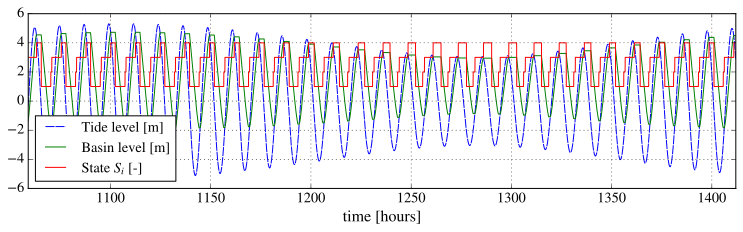

In [ ]:
mpl.plot( hours_vec, tide_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, z_vec, label='Basin level [m]' )
mpl.plot( hours_vec, s_vec, label='State $S_i$ [-]' )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

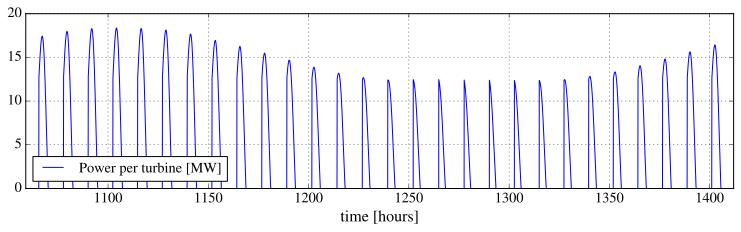

In [ ]:
mpl.plot( hours_vec, PG_vec/1E6, label='Power per turbine [MW]'  )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

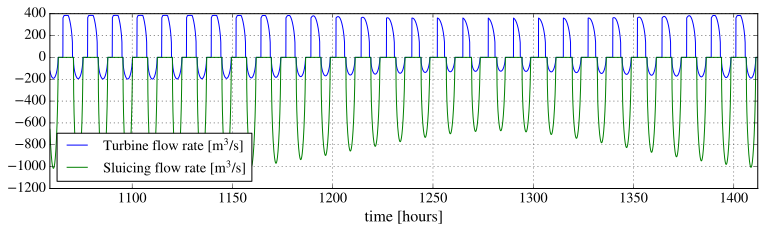

In [ ]:
mpl.plot( hours_vec, QT_vec, label='Turbine flow rate [m$^3$/s]' )
mpl.plot( hours_vec, QS_vec, label='Sluicing flow rate [m$^3$/s]' )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.grid();

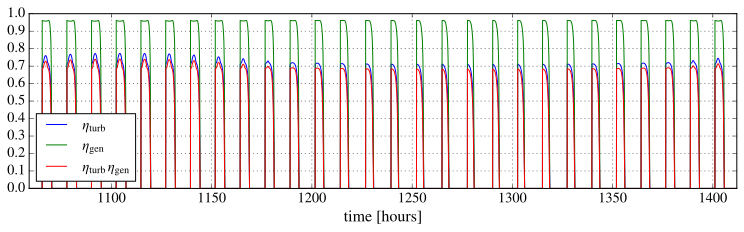

In [ ]:
mpl.plot( hours_vec, ηT_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( hours_vec, ηG_vec, label='$\eta_\mathrm{gen}$' )
mpl.plot( hours_vec, ηT_vec*ηG_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$' )
mpl.xlim( 3*period_hours, 4*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend(loc='lower left')
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid();

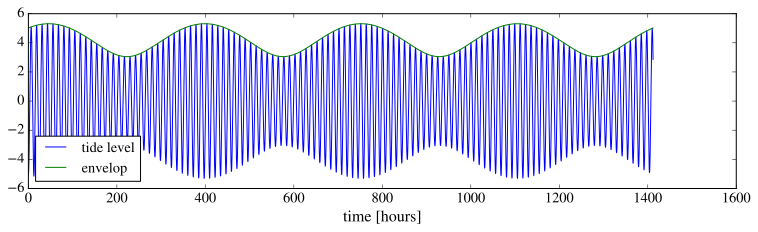

In [ ]:
if len( ω ) == 2:
  X1 = ζ[0]
  X2 = ζ[1]
  ωm = ω[0] - ω[1]
  φm = φ[0] - φ[1]
  ev = np.sqrt(X1**2 + X2**2 + 2*X1*X2*np.cos( ωm*time_vec + φm ) )
  mpl.plot( hours_vec, tide_vec, label="tide level" )
  mpl.plot( hours_vec, ev, label="envelop" )
  #mpl.xlim( 3*period_hours, 4*period_hours )
  mpl.xlabel( 'time [hours]' )
  mpl.legend(loc='lower left');
else:
  print( "No envelop to plot" )